# Exercise on Recurrent Neural Network: SOLUTION 

In this exercise we want to use RNNs for predicting if an ice cream store has ice on stock.
We only can use the past weather to make our predictions and hope that the ice stock depends on the weather in the past couple of days. 
To asses if our RNN model prediction is useful we want to compare the RNN prediction performance to the performance of an easy baseline prediction model. As baseline prediction model we use a random forest.

 
The weather is described by 3 states: 0=sunny, 1=cloudy and 2=rainy. People only buy ice when its sunny and the ice cream 
stand has an unknow stock of ice and reorders sometimes (unknown policy but we hope it depends on the weather).  
Unfortunately, we are quite busy with working so we can  only remember the weather of the last 2 days - for that reason our lookback is only 2 days.


a) Go to the beginning of paragraph *Prepare data* and look at the real data generating process which is coded is in cell 2. Have a look at the code and try to understand the process (not necessary to continue).

**Solution: At each day with nice weather one ice cream stock is sold. If 3 days ago it was cloudy and we have less than 2 ice cream stocks, we order 1 ice cream stock.**

b) Go to the beginning of paragraph *Train and evaluate the baseline Random Forest model*. How large is the accuracy of the random forest model?

**Solution: The accuracy of the RF is ~0.64.**

c) Go to the beginning of paragraph *Train and evaluate the RNN model* and look RNN model definition. Draw the corresponding computational graph of the unrolled model.

**Solution: see the uploaded image of the computational graph**

d) Here's is the model summary of the RNN, explain the Param # for the SimpleRNN layer and Dense layer.
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
simple_rnn_1 (SimpleRNN)     (None, 4)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
=================================================================
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________
```

**Solution:**

**Simple RNN layer: 7x4+4=32 , since we go from 7 nodes (4 from the hidden state, 3 from the input) to 4 nodes (updated hidden state) and also have 4 bias terms for each of the upper 4 nodes.**

**dense: 4x2+2=10 , since we go from 4 nodes (from the hidden state) to 2 nodes (two outcome classes, no-ice or ice) and also have 2 bias terms for each of the upper 2 nodes**

d) What is the size of our hidden state in the model and where do we define it?

**Solution: 
the size is 4 (the first parameter of the SimpleRNN keras function). 
**

e) Do you expect that the ice store has ice on stock on day 2 and day 4?
Hint: Take the trained model and predict the first two examples of the test set

**Solution: 
From the one-hot-encoding we know that the first outcome corresponds to *ice* and the second outcome to *no-ice*. **


**Day 2: prob for outcome 1 is larger than 0.5, meaning we expect to get ice cream. **

**Day 4: prob for outcome 1 is larger than 0.5, meaning we expect to get ice cream.**


f) To understand what excactly is done by the RNN model, check the prediction 
by "hand"/"numpy" with the learned weights from the model.  

Hint: use model.get_weights() to get the leraned weights!

**Solution: Doing the matrix multiplication, tanh- and softmax transformation with the extracted weight matrix leads to the same result as seen in e): 
day 2: prob for outcome=1 is larger than 0.5, meaning we expect to get ice cream 
day 4: prob for outcome=1 is larger than 0.5, meaning we expect to get ice cream 
**

f) Compare the performace of the Random Forrest and the RNN, how good are the models?  
What could be the reason for the observed performances?
Hint: keep in mind the data generating process

**Solution: 
The accuracy of the RF is ~0.64.
The accuracy of the RNN is also ~0.64.
This result is not very surprising, since both models use only the weather information of the last 2 days, but the data generating process has a longer time dependency.
**

f) What do you expect, if you increase the lookback? Play around with this parameter and check if your expectation was right.

**Solution: 
We would expect that with increasing lookback the accuracy gets higher.
This is observed if working with a higher lookback (>2). Hint: adapt the lookback in the paragraph *generating the data*.
**



## Load packages

In [1]:
import numpy as np
import sys
np.random.seed(42)
import tensorflow as tf

import keras
%matplotlib inline
import matplotlib.pyplot as plt
tf.__version__, sys.version_info
import pandas as pd

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Prepare data

In [2]:
def gen_data(size=1000000):
    Xs = np.array(np.random.choice(3, size=(size,))) #Random Weather
    Y = []
    ice = 2 # stock of icecream at start
    for t,x in enumerate(Xs):
        # (t-3) >= 0 the first ice cream could be delivered on day 3
        # Xs[t - 3] cloudy three days before today => we ordered ice cream
        # ice < 2 not full
        if (t - 3) >= 0 and Xs[t - 3] == 1 and ice < 2: 
            ice += 1
        if x == 0: # It is sunny we therefore sell ice, if we have
            if ice > 0: # We have ice cream
                ice -= 1
        if ice > 0: #We are not out of stock
            Y.append(1)
        else:
            Y.append(0)
    return Xs, np.array(Y)

### generating the data and split it to a train valid and test set

In [3]:
X, Y = gen_data(40000) 

lookback=2  # how many days of weather info we use

X_tr = X[0:20000]  # number of days with weather in train data
Y_tr = Y[0:20000]
idx=np.arange(0, len(X_tr),lookback)  
X_train=np.zeros((len(idx),lookback))
Y_train=np.zeros((len(idx),1))
for i in range(0,len(idx)-1):
    X_train[i]=X_tr[idx[i]:idx[i+1]]
    Y_train[i]=Y_tr[idx[i]+lookback]

X_va = X[20000:30000]
Y_va = Y[20000:30000]
idx=np.arange(0, len(X_va),lookback)
X_valid=np.zeros((len(idx),lookback))
Y_valid=np.zeros((len(idx),1))
for i in range(0,len(idx)-1):
    X_valid[i]=X_va[idx[i]:idx[i+1]]
    Y_valid[i]=Y_va[idx[i]+lookback]

X_te = X[30000:40000]
Y_te = Y[30000:40000]
idx=np.arange(0, len(X_te),lookback)
X_test=np.zeros((len(idx),lookback))
Y_test=np.zeros((len(idx),1))
for i in range(0,len(idx)-1):
    X_test[i]=X_te[idx[i]:idx[i+1]]
    Y_test[i]=Y_te[idx[i]+lookback]    

In [4]:
print(X_train.shape)
print(Y_train.shape)

print(X_valid.shape)
print(Y_valid.shape)

print(X_test.shape)
print(Y_test.shape)


(10000, 2)
(10000, 1)
(5000, 2)
(5000, 1)
(5000, 2)
(5000, 1)


### prepare the data for the Random Forrest

In [5]:
X_train_RF=pd.DataFrame(X_train)
for i in range(0,lookback):
    X_train_RF[i]=X_train_RF[i].astype('category')
#X_train_RF.dtypes

Y_train_RF=pd.DataFrame(Y_train)
Y_train_RF[0]=Y_train_RF[0].astype('category')
#Y_train_RF.dtypes

X_test_RF=pd.DataFrame(X_test)
for i in range(0,lookback):
    X_test_RF[i]=X_test_RF[i].astype('category')
#X_train_RF.dtypes

Y_test_RF=pd.DataFrame(Y_test)
Y_test_RF[0]=Y_test_RF[0].astype('category')
#Y_train_RF.dtypes

### converting to one hot encoding for keras

In [6]:
from keras.utils.np_utils import to_categorical   

X_train=to_categorical(X_train,3)
Y_train=to_categorical(Y_train,2)

X_valid=to_categorical(X_valid,3)
Y_valid=to_categorical(Y_valid,2)

X_test=to_categorical(X_test,3)
Y_test=to_categorical(Y_test,2)


## Train and evaluate the baseline Random Forest model

In [7]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=22)
clf.fit(X_train_RF,np.ravel(Y_train_RF))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=22, verbose=0, warm_start=False)

In [8]:
from sklearn.metrics import confusion_matrix
pred=clf.predict(X_test_RF)
print(confusion_matrix(Y_test_RF, pred))
np.sum(pred==Y_test_RF)/len(Y_test_RF)


[[ 998 1076]
 [ 695 2231]]


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


0    0.6458
dtype: float64

## Train and evaluate the RNN model

In [9]:
print(X_train.shape)
print(Y_train.shape)

print(X_valid.shape)
print(Y_valid.shape)

print(X_test.shape)
print(Y_test.shape)


(10000, 2, 3)
(10000, 2)
(5000, 2, 3)
(5000, 2)
(5000, 2, 3)
(5000, 2)


In [10]:
from keras.layers import Activation, Dense, SimpleRNN, TimeDistributed

### define and train RNN model

In [11]:
model = keras.models.Sequential()

name = 'RNN'

model.add(SimpleRNN(4, batch_input_shape=(None,lookback, 3)))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.evaluate(X_train,Y_train)

10000/10000 [==============================] - 1s 78us/step


[0.7736744876861572, 0.4119]

In [14]:
print(model.predict(X_train[0:5]))
print(Y_train[0:5])

[[0.36102727 0.63897276]
 [0.61788523 0.38211474]
 [0.34228864 0.6577113 ]
 [0.4279916  0.57200843]
 [0.61788523 0.38211477]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [15]:
history = model.fit(X_train, Y_train, 
                    batch_size=32,
                    epochs=20, 
                    verbose=2,
                    validation_data=(X_valid,Y_valid))

Train on 10000 samples, validate on 5000 samples
Epoch 1/20
 - 2s - loss: 0.7121 - acc: 0.5264 - val_loss: 0.6817 - val_acc: 0.5980
Epoch 2/20
 - 2s - loss: 0.6797 - acc: 0.5907 - val_loss: 0.6709 - val_acc: 0.5980
Epoch 3/20
 - 1s - loss: 0.6659 - acc: 0.5903 - val_loss: 0.6523 - val_acc: 0.6052
Epoch 4/20
 - 1s - loss: 0.6374 - acc: 0.6467 - val_loss: 0.6263 - val_acc: 0.6470
Epoch 5/20
 - 1s - loss: 0.6258 - acc: 0.6492 - val_loss: 0.6252 - val_acc: 0.6430
Epoch 6/20
 - 1s - loss: 0.6254 - acc: 0.6461 - val_loss: 0.6252 - val_acc: 0.6470
Epoch 7/20
 - 1s - loss: 0.6256 - acc: 0.6497 - val_loss: 0.6249 - val_acc: 0.6470
Epoch 8/20
 - 1s - loss: 0.6253 - acc: 0.6475 - val_loss: 0.6259 - val_acc: 0.6470
Epoch 9/20
 - 1s - loss: 0.6255 - acc: 0.6497 - val_loss: 0.6249 - val_acc: 0.6470
Epoch 10/20
 - 1s - loss: 0.6253 - acc: 0.6497 - val_loss: 0.6251 - val_acc: 0.6470
Epoch 11/20
 - 1s - loss: 0.6255 - acc: 0.6497 - val_loss: 0.6250 - val_acc: 0.6470
Epoch 12/20
 - 1s - loss: 0.6254 - a

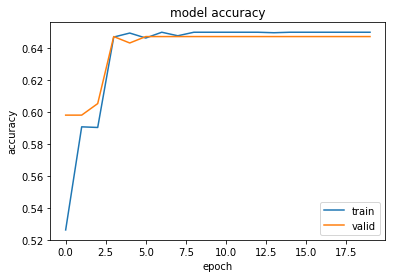

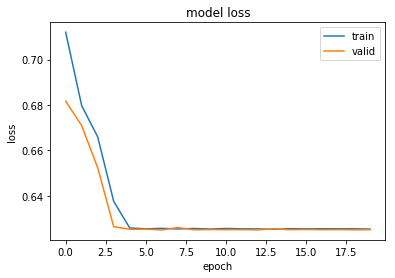

In [16]:
# summarize history
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [17]:
model.get_weights()

[array([[ 0.13438533, -0.21414493,  0.7543685 , -0.94684714],
        [ 0.42468476, -0.833921  , -0.20430444,  0.1835411 ],
        [-0.10851719, -0.8675615 , -0.6149945 , -0.1564514 ]],
       dtype=float32),
 array([[-0.9859326 , -0.06396572,  0.12960972,  0.28472662],
        [ 0.23855513, -0.5735706 ,  0.5790275 , -0.5867164 ],
        [ 0.55517644,  0.6143694 ,  0.476472  , -0.18081167],
        [-0.0607311 ,  0.12541582,  0.35965323,  0.5499555 ]],
       dtype=float32),
 array([ 0.13443226, -0.11679035,  0.13469532, -0.00901049], dtype=float32),
 array([[-0.13889404, -0.4586342 ],
        [ 0.7196145 ,  0.15101716],
        [-0.05102399, -0.4032456 ],
        [-0.78012294, -0.1269002 ]], dtype=float32),
 array([-0.07231462,  0.07231498], dtype=float32)]

In [18]:
W1=np.row_stack(model.get_weights()[0:2])
b1=model.get_weights()[2]
W2=model.get_weights()[3]
b2=model.get_weights()[4]

## Use the trained model for prediction

In [19]:
y_pred1=model.predict(X_test[0:1])[0]
y_pred1

array([0.24401577, 0.7559842 ], dtype=float32)

### forwardpass in numpy by "hand"

In [20]:
h0=np.array((0,0,0,0),dtype="float32")
#first hidden statee = all zeros

In [21]:
h1=np.tanh(np.matmul(np.concatenate((X_test[0][0],h0)),W1)+b1)

In [22]:
h2=np.tanh(np.matmul(np.concatenate((X_test[0][1],h1)),W1)+b1)

In [23]:
Z=np.matmul(h2,W2)+b2
np.exp(Z)/np.sum(np.exp(Z))

array([0.2440158, 0.7559842])

In [24]:
#in a loop:
ht=np.array((0,0,0,0),dtype="float32")#first hidden stare = all zeros
for i in range(0,lookback):
    ht=np.tanh(np.matmul(np.concatenate((X_test[0][i],ht)),W1)+b1)
Z=np.matmul(ht,W2)+b2
np.exp(Z)/np.sum(np.exp(Z))

array([0.2440158, 0.7559842])

In [25]:
pred=model.predict(X_test)
print(confusion_matrix(np.argmax(Y_test,axis=1), np.argmax(pred,axis=1)))
np.sum(np.argmax(pred,axis=1)==np.argmax(Y_test,axis=1))/len(Y_test)

[[ 998 1076]
 [ 695 2231]]


0.6458